In [1]:
import os
os.chdir('../../')

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Mon Mar 31 07:29:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 30%   48C    P2            122W /  350W |    2095MiB /  24576MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### from "sample pair.ipynb"

In [3]:
import torch
import torch.nn.functional as F

total_samples = 256
save_file = f'/data/optimization/euler_NFE=1000_N={total_samples}_imagenet64.pt'
pairs = torch.load(save_file)
noise = pairs[:, 0]
target = pairs[:, 1]
print(noise.shape, target.shape)

torch.Size([256, 3, 64, 64]) torch.Size([256, 3, 64, 64])


In [10]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "3",
    "--skip_type", "logSNR",
    "--ni",

    "--sample_type", "rbfsolverglq10",
    "--timesteps", "5",
    "--log_scale_min", "-2.0",
    "--log_scale_max", "6.0",
    "--log_scale_num", "1000",
    "--scale_dir", "/data/data/rbfsolverglq10",
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device


INFO - main.py - 2025-03-31 07:32:12,159 - Using device: cuda
INFO - main.py - 2025-03-31 07:32:12,159 - Using device: cuda


[prepare_model] Model is ready.


In [11]:
!mkdir /data/data/rbfsolverglq10
!ls /data/data/rbfsolverglq10

mkdir: cannot create directory ‘/data/data/rbfsolverglq10’: File exists
'NFE=10,p=100,dataset=IMAGENET128.npy'	'NFE=20,p=3,dataset=IMAGENET128.npy'
'NFE=10,p=10,dataset=IMAGENET128.npy'	'NFE=20,p=3,dataset=IMAGENET64.npy'
'NFE=10,p=10,dataset=IMAGENET64.npy'	'NFE=25,p=3,exp_num=0.npy'
'NFE=10,p=3,dataset=IMAGENET128.npy'	'NFE=25,p=3.npy'
'NFE=10,p=3,dataset=IMAGENET64.npy'	'NFE=5,p=100,dataset=IMAGENET128.npy'
'NFE=10,p=3,exp_num=0.npy'		'NFE=5,p=100,dataset=IMAGENET64.npy'
'NFE=10,p=3.npy'			'NFE=5,p=10,dataset=IMAGENET128.npy'
'NFE=15,p=100,dataset=IMAGENET128.npy'	'NFE=5,p=10,dataset=IMAGENET64.npy'
'NFE=15,p=3,exp_num=0.npy'		'NFE=5,p=3,dataset=IMAGENET128.npy'
'NFE=15,p=3.npy'			'NFE=5,p=3,dataset=IMAGENET64.npy'
'NFE=20,p=100,dataset=IMAGENET128.npy'	'NFE=5,p=3,exp_num=0.npy'
'NFE=20,p=10,dataset=IMAGENET128.npy'	'NFE=5,p=3.npy'


In [12]:
n = 64
noise_batch = noise[:n].to(device)
target_batch = target[:n].to(device)
print(noise_batch.shape)
#(pred, optimal_gammas, pred_losses_list, corr_losses_list), _ = diffusion.sample_image(noise_batch, diffusion.model, classifier=diffusion.classifier, target=target_batch)
(pred, optimal_gammas, pred_losses_list, corr_losses_list), _ = diffusion.sample_image(noise_batch, diffusion.model, target=target_batch)
loss = F.mse_loss(pred, target_batch)
print('loss :', loss)
print(optimal_gammas)


torch.Size([64, 3, 64, 64])
/data/data/rbfsolverglq10/NFE=5,p=3,dataset=IMAGENET64.npy  saved!
loss : tensor(0.0321, device='cuda:0')
[[-2.          0.37837838  5.06306306  5.96796797 -2.        ]
 [-0.71071071 -0.19019019 -0.12612613  4.82282282  0.        ]]


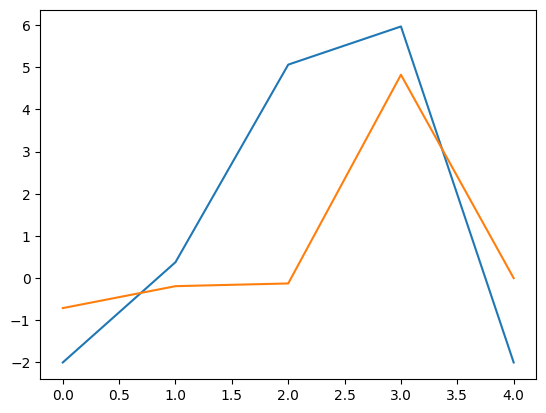

In [13]:
plt.plot(optimal_gammas[0])
plt.plot(optimal_gammas[1])
plt.show()

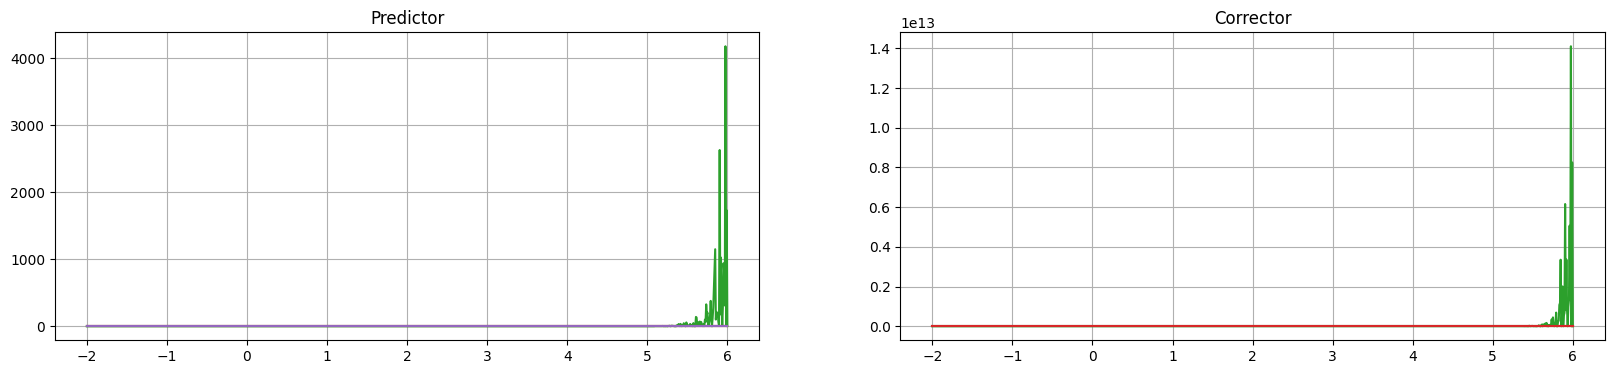

In [14]:
import matplotlib.pyplot as plt
x_axis = np.linspace(args.log_scale_min, args.log_scale_max, args.log_scale_num)

plt.figure(figsize=[20, 4])
plt.subplot(1, 2, 1)
plt.title('Predictor')
for i in range(len(pred_losses_list)):
    plt.plot(x_axis, pred_losses_list[i])
#plt.ylim([0.0, 1])
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Corrector')
for i in range(len(corr_losses_list)):
    plt.plot(x_axis, corr_losses_list[i])
#plt.ylim([0.0, 1])
plt.grid()
plt.show()

### Batch

In [9]:
import sys
import torch
import numpy as np
import random

from main import parse_args_and_config, Diffusion
from tqdm import tqdm
import torch.nn.functional as F

total_samples = 32
save_file = f'/data/optimization/euler_NFE=120_N={total_samples}_imagenet128.pt'
pairs = torch.load(save_file)
noise = pairs[:, 0]
target = pairs[:, 1]
print(noise.shape, target.shape)

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

for NFE in tqdm([5, 10, 20]):
    ###############################################################################
    # 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
    ###############################################################################
    sys.argv = [
        "main.py",
        "--config", "imagenet128_guided.yml",  # 사용하려는 config
        "--sample",
        "--eta", "0",
        "--dpm_solver_type", "data_prediction",
        "--dpm_solver_order", "3",
        "--skip_type", "logSNR",
        "--scale", "0.0",
        "--thresholding",
        "--ni",
        "--verbose", 'critical',

        "--sample_type", "rbfsolverglq10",
        "--timesteps", str(NFE),
        "--log_scale_min", "-6.0",
        "--log_scale_max", "6.0",
        "--log_scale_num", "100",
        "--scale_dir", "/data/data/rbfsolverglq10",
    ]

    ###############################################################################
    # 2) 인자/설정 로드
    ###############################################################################
    args, config = parse_args_and_config()

    ###############################################################################
    # 3) Diffusion 객체 생성 -> 모델 로딩
    ###############################################################################
    diffusion = Diffusion(args, config, rank=0)
    diffusion.prepare_model()
    diffusion.model.eval()

    ###############################################################################
    # 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
    ###############################################################################
    device = diffusion.device

    n = 32
    noise_batch = noise[:n].to(device)
    target_batch = target[:n].to(device)
    (pred, optimal_gammas), _ = diffusion.sample_image(noise_batch, diffusion.model, classifier=diffusion.classifier, target=target_batch)
    print(F.mse_loss(pred, target_batch))
    print(optimal_gammas)


FileNotFoundError: [Errno 2] No such file or directory: '/data/optimization/euler_NFE=120_N=32_imagenet128.pt'